<a href="https://colab.research.google.com/github/rahiakela/data-science-research-and-practice/blob/main/feature-engineering-bookcamp/02_modeling_recidivism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

In [ ]:
%%capture%%

!pip install feature-engine

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import time
np.random.seed(0)
import random
random.seed(0)

In [4]:
from sklearn.impute import SimpleImputer
from feature_engine.imputation import EndTailImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel

from sklearn.tree import DecisionTreeClassifier

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer  # class to help make dummy variables
from functools import reduce

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split

from scipy.stats import zscore

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!wget https://github.com/sinanuozdemir/feature_engineering_bookcamp/raw/main/data/compas-scores-two-years.csv

##Dataset

In [7]:
compas_df = pd.read_csv("compas-scores-two-years.csv")
compas_df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [8]:
compas_df.shape

(7214, 53)

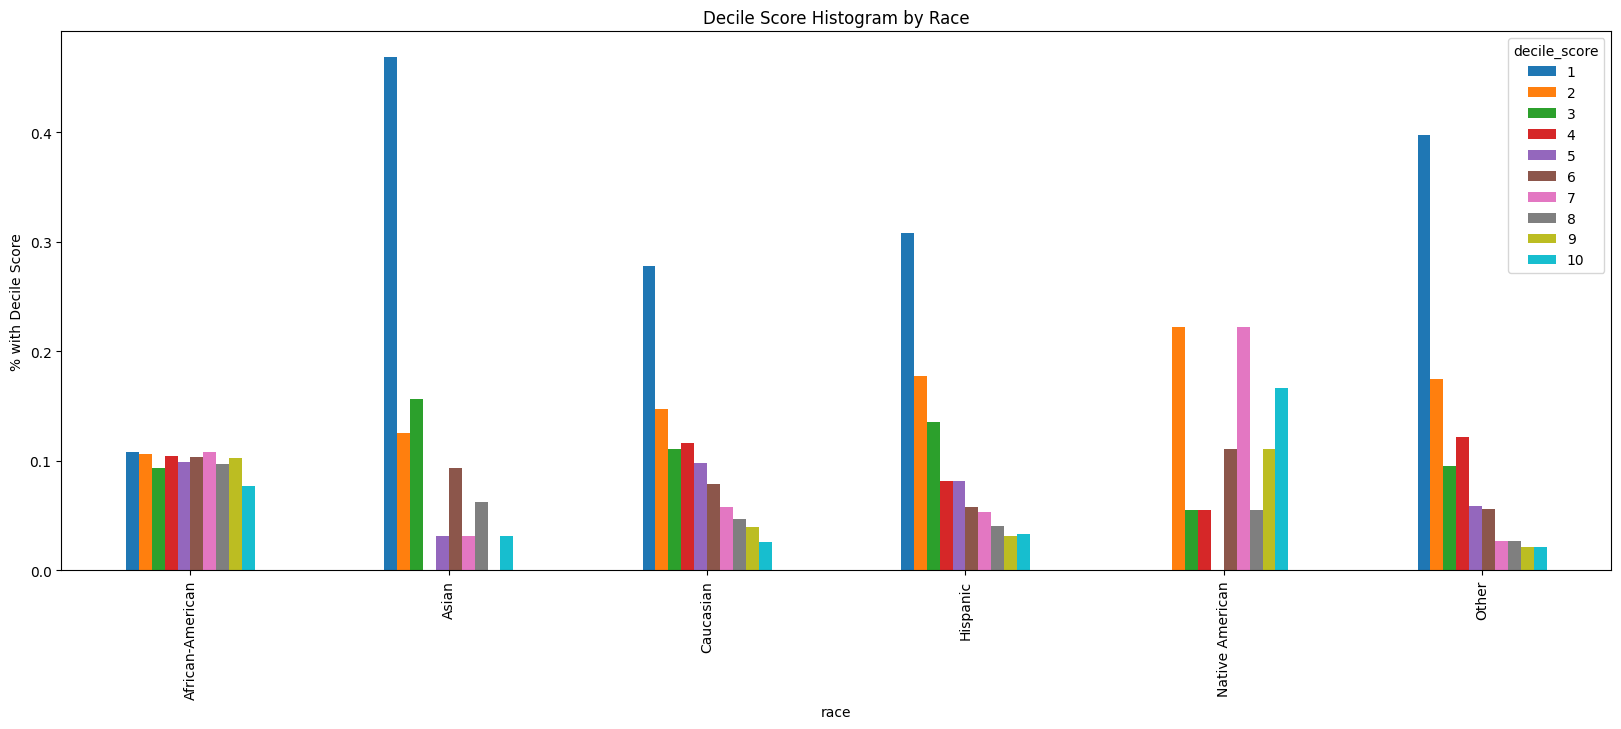

In [9]:
# Let’s plot a histogram of decile scores by race
compas_df.groupby("race")["decile_score"].value_counts(
    normalize=True
    ).unstack().plot(
             kind="bar",
             figsize=(20, 7),
             title="Decile Score Histogram by Race",
             ylabel="% with Decile Score"
         );

In [10]:
# let's do inspecting some basic statistics around decile scores by race
compas_df.groupby("race")["decile_score"].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,5.368777,2.831122,1.0,3.00,5.0,8.00,10.0
Asian,32.0,2.937500,2.601953,1.0,1.00,2.0,3.50,10.0
Caucasian,2454.0,3.735126,2.597926,1.0,1.00,3.0,5.00,10.0
Hispanic,637.0,3.463108,2.599100,1.0,1.00,3.0,5.00,10.0
Native American,18.0,6.166667,2.975389,2.0,3.25,7.0,8.75,10.0
Other,377.0,2.949602,2.350895,1.0,1.00,2.0,4.00,10.0


##Exploratory data analysis

In [12]:
# Let’s look at the breakdown of recidivism, by race
compas_df.groupby("race")["two_year_recid"].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,3696.0,0.514340,0.499862,0.0,0.0,1.0,1.0,1.0
Asian,32.0,0.281250,0.456803,0.0,0.0,0.0,1.0,1.0
Caucasian,2454.0,0.393643,0.488657,0.0,0.0,0.0,1.0,1.0
Hispanic,637.0,0.364207,0.481585,0.0,0.0,0.0,1.0,1.0
Native American,18.0,0.555556,0.511310,0.0,0.0,1.0,1.0,1.0
Other,377.0,0.352785,0.478472,0.0,0.0,0.0,1.0,1.0


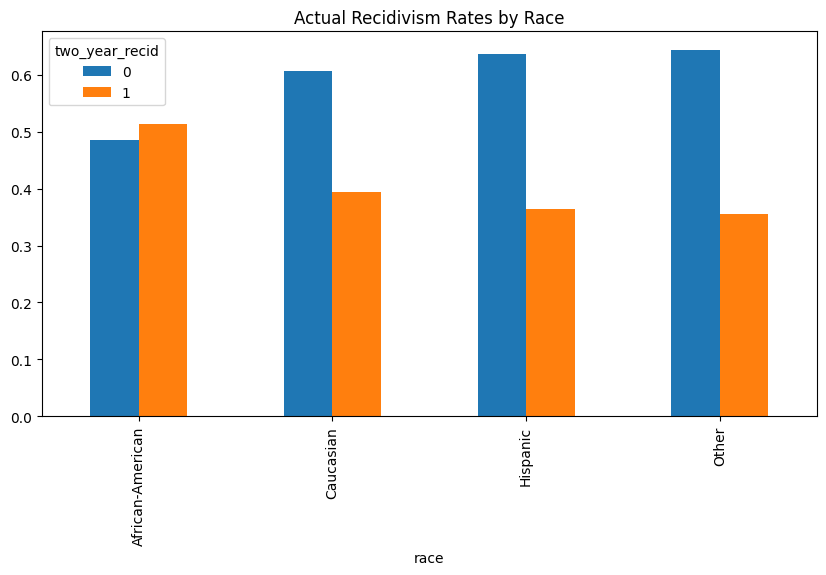

In [13]:
# Relabeling underrepresented races as Other
compas_df.loc[compas_df["race"].isin(["Native American", "Asian"]), "race"] = "Other"
compas_df.groupby("race")["two_year_recid"].value_counts(
    normalize=True
    ).unstack().plot(
             kind="bar",
             figsize=(10, 5),
             title="Actual Recidivism Rates by Race",
         );

<Axes: title={'center': '% of Charge Degree'}, xlabel='Charge Degree', ylabel='%'>

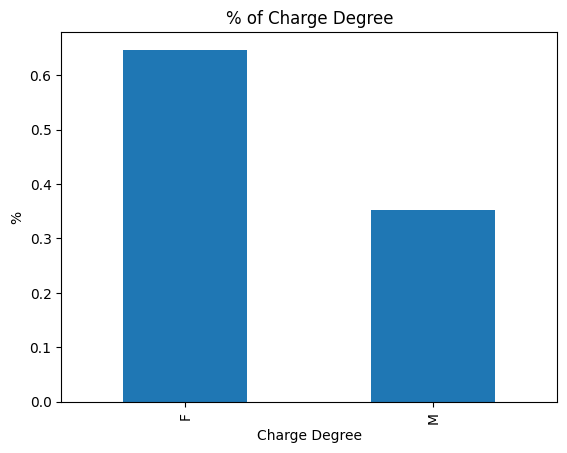

In [14]:
# let's encode binary charge degree feature as Boolean
compas_df["c_charge_degree"].value_counts(normalize=True).plot(
    kind="bar",
    title="% of Charge Degree",
    ylabel="%",
    xlabel="Charge Degree"
)

<Axes: title={'center': 'Histogram of Age'}, xlabel='Age', ylabel='Frequency'>

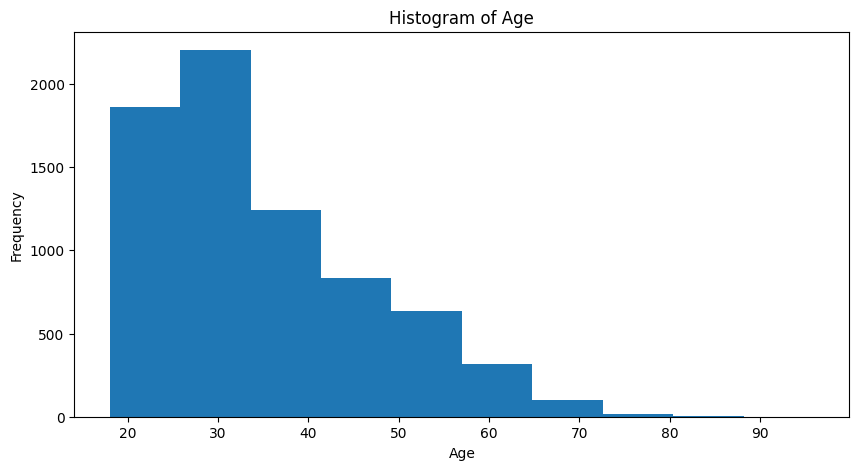

In [16]:
# Plotting histograms of our quantitative variables
compas_df["age"].plot(
    kind="hist",
    title="Histogram of Age",
    xlabel="Age",
    figsize=(10, 5)
)

<Axes: title={'center': 'Histogram of Priors Count'}, xlabel='Priors', ylabel='Frequency'>

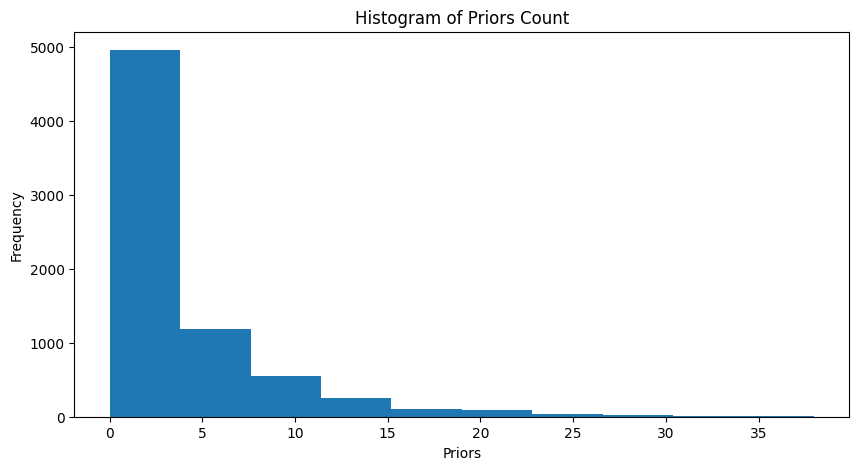

In [17]:
compas_df["priors_count"].plot(
    kind="hist",
    title="Histogram of Priors Count",
    xlabel="Priors",
    figsize=(10, 5)
)

##Measuring bias and fairness